<a href="https://colab.research.google.com/github/Vykp00/intelligent-systems-ML-for-production/blob/main/2-Image-Processing/CIFAR_10_CNN_vs_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 CNN and ResNet Reinfornce Learning**
This notebook demonstrates the performance differences of using a Convolutional Neural Network (CNN) to classify CIFAR-10 images vs ResNet Reinfornce Learning. The CNN use [TFX Tuner](https://www.tensorflow.org/tfx/guide) for creating a [Machine Learning Pipeline](https://www.tensorflow.org/tfx/tutorials/tfx/components_keras). Why TFX:
* The Tuner utilizes the Keras Tuner API under the hood to tune your model's hyperparameters.
* You can get the best set of hyperparameters from the Tuner component and feed it into the Trainer component to optimize your model for training.

# **1. Set up**
We first need to install TensorFlow the TFX Python package and download the dataset which we will use for our model. This may take 5-10 minutes

In [ ]:
# Requires the latest pip
# !pip install --upgrade pip

# Current stable release for CPU and GPU 2.13.1 or 2.15.0
# !pip install -q tensorflow==2.13.1
!pip install tensorflow[and-cuda]

In [2]:
# Install TFX 1.14.0
# !pip install -q tfx==1.14.0
!pip install tfx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Incase ImportError
!pip uninstall shapely -y

Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2


## Install Keras_Tuner

In [2]:
# !pip install -q keras-tuner==1.4.6
!pip install -q -U keras-tuner

## Import Packages
After install TensorFlow and TFX, we can try importing the package

```
# TensorFlow version: 2.13.1
# TFX version: 1.14.0
# Keras Tuner version: 1.4.6
```



In [5]:
import os
import pprint

import tensorflow as tf
from tfx import v1 as tfx
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_tuner as kt

import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from absl import logging
from tfx.proto import example_gen_pb2, trainer_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input

from google.protobuf.json_format import MessageToDict


pp = pprint.PrettyPrinter()

# Disables the propagation of log messages to higher level loggers.
tf.get_logger().propagate = False

# Only log messages that are at the 'ERROR' level or higher. Ignore 'DEBUG', 'INFO', 'WARNING'
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Check TensorFlow, TFX and KerasTuner version
# print(tf.config.list_physical_devices('GPU'))
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('Keras Tuner version: {}'.format(kt.__version__))

TensorFlow version: 2.13.1
TFX version: 1.14.0
Keras Tuner version: 1.4.6


# **2. Data Preprocessing**
Before building any ML model, it is important to preprocess the data. In fact, data preprocessing will generally take up the most time in any ML pipeline. The following module goes over the steps to preprocess the CIFAR10 dataset for our purposes.

## Download and prepare the CIFAR10 dataset
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

Our first step is to setup the directories that will be used to store the dataset, as well as the pipeline artifacts and metadata store.

In [7]:
# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Directory of the raw data files
_data_root = './data/cifar'

# Temporary directory
tempdir = './tempdir'

In [8]:
# Create the dataset directory
!mkdir -p {_data_root}

# Create the TFX pipeline files directory
!mkdir {_pipeline_root}

Our next step is to load the data and divide it into a training and testing dataset. The CIFAR10 dataset can be downloaded directly from TensorFlow and has already been divided. Run the next cell to import the data.The `with_info` flag will be set to True so you can display information about the dataset in the next cell (i.e. using `ds_info`).

In [9]:
# Download the dataset
ds, ds_info = tfds.load('cifar10', data_dir=tempdir, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling tempdir/cifar10/3.0.2.incompleteYH56SZ/cifar10-train.tfrecord*...:   0%|          | 0/50000 [00:00<?…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling tempdir/cifar10/3.0.2.incompleteYH56SZ/cifar10-test.tfrecord*...:   0%|          | 0/10000 [00:00<?,…

Dataset cifar10 downloaded and prepared to ./tempdir/cifar10/3.0.2. Subsequent calls will reuse this data.


In [10]:
# Display info about the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpe_sd3rohtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

You can review the downloaded files with the code below. We need to use train TFRecord and test TFRecord so be sure to remember the file name.

**Example Output:**

`['features.json',
 'cifar10-test.tfrecord-00000-of-00001',
 'cifar10-train.tfrecord-00000-of-00001',
 'label.labels.txt',
 'dataset_info.json']`

In [11]:
# Define the location of the train tfrecord downloaded via TFDS
tfds_data_path = f'{tempdir}/{ds_info.name}/{ds_info.version}'

# Display contents of the TFDS data directory
os.listdir(tfds_data_path)

['cifar10-test.tfrecord-00000-of-00001',
 'features.json',
 'cifar10-train.tfrecord-00000-of-00001',
 'dataset_info.json',
 'label.labels.txt']

You will then copy the train split from the downloaded data so it can be consumed by the ExampleGen component in the next step. This component requires that your files are in a directory without extra files (e.g. JSONs and TXT files).

In [12]:
# Define the train tfrecord filename
train_filename = 'cifar10-train.tfrecord-00000-of-00001'

# Define the test tfrecord filename
test_filename = 'cifar10-test.tfrecord-00000-of-00001'

# Copy the train tfrecord into the data root folder
!cp {tfds_data_path}/{train_filename} {_data_root}

In [13]:
'''

`x_train` is the dataset of 32x32 color images of objects that the model will be trained on.

`y_train` is the dataset of labels that correspond to x_train.

`x_test` is the dataset of 32x32 color images of objects that the model will be tested on.

`y_test` is the dataset of labels that correspond to x_test.

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_test / 255.0, x_test / 255.0
'''

'\n\n`x_train` is the dataset of 32x32 color images of objects that the model will be trained on.\n\n`y_train` is the dataset of labels that correspond to x_train.\n\n`x_test` is the dataset of 32x32 color images of objects that the model will be tested on.\n\n`y_test` is the dataset of labels that correspond to x_test.\n\n(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()\n\n# Normalize pixel values to be between 0 and 1\nx_train, x_test = x_test / 255.0, x_test / 255.0\n'

# **3. TFX PipeLine**
Now the set up is complete. We can now proceed to creating the pipeline for [`Trainer`](https://www.tensorflow.org/tfx/tutorials/tfx/components_keras#trainer) Component

## **3.1 Feature Engineering**
Before building the pipeline, we need to transform the data by conducting feature engineering with the images

## Initialize the Interactive Context
We will start by initializing the `InteractiveContext` so you can run the components within this environment. We can safely ignore the warning because we will just be using a local SQLite file for the metadata store.

In [14]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root)

## ExampleGen
You will start the pipeline by ingesting the TFRecord you set aside. The [ImportExampleGen](https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/ImportExampleGen) consumes TFRecords and you can specify splits as shown below. Because this dataset is already in TFRecord format, we won't need to convert it with `ExampleGen` which is often needed for TFX pipeline.

In [15]:
# Specify 80/20 split for the train and eval set
output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=8),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=2),
    ]))

# Ingest the data through ExampleGen
example_gen = tfx.components.ImportExampleGen(input_base=_data_root, output_config=output)

# Run the component
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [16]:
# Print split names and URI
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] ./pipeline/ImportExampleGen/examples/1


You can also take a look at the first three training examples ingested by using the `tf.io.parse_single_example()` method from the tf.io module. See how it is setup in the cell below.

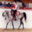

'Class ID: 7'


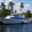

'Class ID: 8'


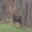

'Class ID: 4'


In [17]:
import IPython.display as display

# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Description per example
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

# Image parser function
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

# Map the parser to the dataset
parsed_image_dataset = dataset.map(_parse_image_function)

# Display the first three images
for features in parsed_image_dataset.take(3):
    image_raw = features['image'].numpy()
    display.display(display.Image(data=image_raw))
    pprint.pprint('Class ID: {}'.format(features['label'].numpy()))

## StatisticsGen
Next, Compute the statistics of the dataset with the [StatisticsGen](https://www.tensorflow.org/tfx/guide/statsgen) component.

In [18]:
# Run StatisticGen
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'])

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

## SchemaGen
You can then infer the dataset schema with [SchemaGen](https://www.tensorflow.org/tfx/guide/schemagen). This will be used to validate incoming data to ensure that it is formatted correctly. With CIFAR-10, there is a column for the image and another column for the numeric label.

In [19]:
# Run SchemaGen
schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [20]:
# Visualize the results
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'id',BYTES,required,,-
'image',BYTES,required,,-
'label',INT,required,,-


**Citation**
@TECHREPORT{Krizhevsky09learningmultiple,
    author = {Alex Krizhevsky},
    title = {Learning multiple layers of features from tiny images},
    institution = {},
    year = {2009}
}

## ExampleValidator
We can assume that the dataset is clean since we downloaded it from TFDS. But in real life, we need to run it through ExampleValidator to detect if there are anomalies within the dataset.

In [21]:
# Run ExampleValidator
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [22]:
# Visualize the results. There should be no anomalies.
context.show(example_validator.outputs['anomalies'])

## Transform
Let's now use the [Transform](https://www.tensorflow.org/tfx/guide/transform) component to scale the image pixels and convert the data types to float. We will first define the transform module containing these operations before you run the component.

To successfully transform the raw image, you need to parse the current bytes format and convert it to a tensor. For that, We can use the `tf.image.decode_image()` function. The transform module below utilizes this and converts the image to a `(32,32,3)` shaped float tensor. It also scales the pixels and converts the labels to one-hot tensors. The output features should then be ready to pass on to a model that accepts this format.

In [23]:
_transform_module_file = 'cifar_transform.py'

In [24]:
print(tf.config.list_physical_devices('GPU'))

[]


In [140]:
%%writefile {_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

# Keys
_LABEL_KEY = 'label'
_IMAGE_KEY = 'image'


def _transformed_name(key):
    return key + '_xf'

def _image_parser(image_str):
    '''converts the images to a float tensor'''
    image = tf.image.decode_image(image_str, channels=3) # Because it's color image, there're 3 channels
    image = tf.reshape(image, (32, 32, 3))
    image = tf.cast(image, tf.float32)
    return image

def _label_parser(label_id):
    '''one hot encodes the labels '''
    label = tf.one_hot(label_id, 10)
    return label

def preprocessing_fn(inputs):
    '''
    tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    '''

    # Convert the raw image and labels to a float array and
    # one-hot encoded labels, respectively.
    with tf.device("/cpu:0"):
      outputs = {
          _transformed_name(_IMAGE_KEY):
            tf.map_fn(
                _image_parser,
                tf.squeeze(inputs[_IMAGE_KEY], axis=1),
                dtype=tf.float32),
          _transformed_name(_LABEL_KEY):
            tf.map_fn(
                _label_parser,
                tf.squeeze(inputs[_LABEL_KEY], axis=1),
                dtype=tf.float32)
      }
    # scale the pixels from 0 to 1
    outputs[_transformed_name(_IMAGE_KEY)] = tft.scale_to_0_1(outputs[_transformed_name(_IMAGE_KEY)])

    return outputs

Overwriting cifar_transform.py


Now, we pass in this feature engineering code to the `Transform` component and run it to transform your data.

In [141]:
# Setup the Transform component
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file)
)

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 31
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

## Preview the results
Now that the Transform component is finished, we can preview how the transformed images and labels look like.

In [142]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [137]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
  '''Extracts records from the given dataset.
      Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
  '''

  # initialize an empty list
  records = []

  # Use the `take()` method to specify how many records to get
  for tfrecord in dataset.take(num_records):

      # Get the numpy property of the tensor
      serialized_example = tfrecord.numpy()

      # Initialize a `tf.train.Example()` to read the serialized data
      example = tf.train.Example()

      # Read the example data (output is a protocol buffer message)
      example.ParseFromString(serialized_example)

      # Convert the protocol buffer message to a Python dictionary
      example_dict = (MessageToDict(example))

      # Append to the records list
      records.append(example_dict)
  return records

From the output of the cell below that the transformed raw image (i.e. `image_xf`) now has a float array that is scaled from 0 to 1. Similarly, you'll see that the transformed label (i.e. `label_xf`) is now one-hot encode

In [143]:
# Get 1 record from the dataset
sample_records = get_records(dataset, 1)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'image_xf': {'floatList': {'value': [0.56078434,
                                                                0.3764706,
                                                                0.27450982,
                                                                0.5529412,
                                                                0.3764706,
                                                                0.28235295,
                                                                0.5294118,
                                                                0.3647059,
                                                                0.28235295,
                                                                0.53333336,
                                                                0.3764706,
                                                                0.30588236,
                                                                0.5137255,
                   

## **3.2 Hyperparameter Tuning**
## Tuner

The [Tuner](https://www.tensorflow.org/tfx/guide/tuner) component tunes the hyperparameters of your model. To use this, we need to provide a tuner module file which contains a `tuner_fn()` function.

The Transform component earlier saved the transformed examples as TFRecords compressed in `.gz` format and we will load that into memory. Once loaded, we need to create batches of features and labels so we can finally use it for hypertuning. This process is modularized in the `_input_fn()` below.

The `tuner_fn()` function will return a `TunerFnResult` [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) containing your tuner object and a set of arguments to pass to `tuner.search()` method. When reviewing the module file, we recommend viewing the `tuner_fn()` first before looking at the other auxiliary functions.



The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [118]:
! rm 'tuner.py'

In [119]:
# Declare name of module file
_tuner_module_file = 'tuner.py'

In [133]:
%%writefile {_tuner_module_file}

# Define imports
from kerastuner.engine import base_tuner
import kerastuner as kt
from tensorflow import keras
from typing import NamedTuple, Dict, Text, Any, List
from tfx.components.trainer.fn_args_utils import FnArgs, DataAccessor
import tensorflow as tf
import tensorflow_transform as tft

# Declare namedtuple field names
TunerFnResult = NamedTuple('TunerFnResult', [('tuner', base_tuner.BaseTuner),
                                             ('fit_kwargs', Dict[Text, Any])])

# Input key
_IMAGE_KEY = 'image_xf'

# Label key
_LABEL_KEY = 'label_xf'

# Callback for the search strategy
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


def _gzip_reader_fn(filenames):
  '''Load compressed dataset

  Args:
    filenames - filenames of TFRecords to load

  Returns:
    TFRecordDataset loaded from the filenames
  '''

  # Load the dataset. Specify the compression type since it is saved as `.gz`
  return tf.data.TFRecordDataset(filenames, compression_type='GZIP')


def _input_fn(file_pattern,
              tf_transform_output,
              num_epochs=None,
              batch_size=32) -> tf.data.Dataset:
  '''Create batches of features and labels from TF Records

  Args:
    file_pattern - List of files or patterns of file paths containing Example records.
    tf_transform_output - transform output graph
    num_epochs - Integer specifying the number of times to read through the dataset.
            If None, cycles through the dataset forever.
    batch_size - An int representing the number of records to combine in a single batch.

  Returns:
    A dataset of dict elements, (or a tuple of dict elements and label).
    Each dict maps feature keys to Tensor or SparseTensor objects.
  '''

  # Get feature specification based on transform output
  transformed_feature_spec = (
      tf_transform_output.transformed_feature_spec().copy())

  # Create batches of features and labels
  dataset = tf.data.experimental.make_batched_features_dataset(
      file_pattern=file_pattern,
      batch_size=batch_size,
      features=transformed_feature_spec,
      reader=_gzip_reader_fn,
      num_epochs=num_epochs,
      label_key=_LABEL_KEY)

  return dataset


def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune

  '''

  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name=_IMAGE_KEY))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu')) #Since dataset is color image
  model.add(keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_layer1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

def tuner_fn(fn_args: FnArgs) -> TunerFnResult:
  """Build the tuner using the KerasTuner API.
  Args:
    fn_args: Holds args as name/value pairs.

      - working_dir: working dir for tuning.
      - train_files: List of file paths containing training tf.Example data.
      - eval_files: List of file paths containing eval tf.Example data.
      - train_steps: number of train steps.
      - eval_steps: number of eval steps.
      - schema_path: optional schema of the input data.
      - transform_graph_path: optional transform graph produced by TFT.

  Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
  """

  # Define tuner search strategy
  tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=fn_args.working_dir,
                     project_name='kt_hyperband')

  # Load transform output
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)

  # Use _input_fn() to extract input features and labels from the train and val set
  train_set = _input_fn(fn_args.train_files[0], tf_transform_output)
  val_set = _input_fn(fn_args.eval_files[0], tf_transform_output)


  return TunerFnResult(
      tuner=tuner,
      fit_kwargs={
          "callbacks":[stop_early],
          'x': train_set,
          'validation_data': val_set,
          'steps_per_epoch': fn_args.train_steps,
          'validation_steps': fn_args.eval_steps
      }
  )

Overwriting tuner.py


With the module defined, you can now setup the Tuner component. You can see the description of each argument here.

Notice that we passed a num_steps argument to the train and eval args and this was used in the steps_per_epoch and validation_steps arguments in the tuner module above. This can be useful if you don't want to go through the entire dataset when tuning. For example, if you have 10GB of training data, it would be incredibly time consuming if you will iterate through it entirely just for one epoch and one set of hyperparameters. You can set the number of steps so your program will only go through a fraction of the dataset.

You can compute for the total number of steps in one epoch by: number of examples / batch size. For this particular example, we have 48000 examples / 32 (default size) which equals 1500 steps per epoch for the train set (compute val steps from 12000 examples). Since you passed 500 in the num_steps of the train args, this means that some examples will be skipped. This will likely result in lower accuracy readings but will save time in doing the hypertuning. Try modifying this value later and see if you arrive at the same set of hyperparameters.

Now we pass the `Tuner` component to the `Trainer` by filling the hyperparameters argument with the Tuner output. This is indicated by the `tuner.outputs['best_hyperparameters']` below. The definition of the other arguments [here](https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/Trainer).

In [105]:
# Setup the Tuner component
tuner = tfx.components.Tuner(
    module_file=_tuner_module_file,
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=500),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=100)
    )

In [139]:
# Run the component. This will take around 10 minutes to run.
# When done, it will summarize the results and show the 10 best trials.
context.run(tuner, enable_cache=False)

ValueError: The `label_key` provided (label_xf) must be one of the `features` keys: dict_keys(['image_xf_input', 'label_xf_input']).

In [ ]:
# Setup the Trainer component
trainer = tfx.components.Trainer(
    module_file=_trainer_module_file,
    examples=transform.outputs['transformed_examples'],
    hyperparameters=tuner.outputs['best_hyperparameters'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval']))

**Note:** When re-training this model, we don't always have to retune the hyperparameters. Once we have a set that we think performs well, we can just import it with the `Importer` component as shown in the [official docs](https://www.tensorflow.org/tfx/guide/tuner):



```
hparams_importer = Importer(
    # This can be Tuner's output file or manually edited file. The file contains
    # text format of hyperparameters (keras_tuner.HyperParameters.get_config())
    source_uri='path/to/best_hyperparameters.txt',
    artifact_type=HyperParameters,
).with_id('import_hparams')

trainer = Trainer(
    ...
    # An alternative is directly use the tuned hyperparameters in Trainer's user
    # module code and set hyperparameters to None here.
    hyperparameters = hparams_importer.outputs['result'])
```



In [ ]:
# Run the component
context.run(trainer, enable_cache=False)

The model should now be saved in the `./pipeline` directory and we can navigate through it as shown below. The file is saved as `saved_model.pb`.

In [ ]:
# Get artifact uri of trainer model output
model_artifact_dir = trainer.outputs['model'].get()[0].uri

# List subdirectories artifact uri
print(f'contents of model artifact directory:{os.listdir(model_artifact_dir)}')

# Define the model directory
model_dir = os.path.join(model_artifact_dir, 'Format-Serving')

# List contents of model directory
print(f'contents of model directory: {os.listdir(model_dir)}')

You can also visualize the training results by loading the logs saved by the Tensorboard callback.

In [ ]:
model_run_artifact_dir = trainer.outputs['model_run'].get()[0].uri

%load_ext tensorboard
%tensorboard --logdir {model_run_artifact_dir}